# Algorithm 4

## Introduction

We call a decision-making process to suffer from disparate mistreatment (DM) concerning a given sensitive attribute (e.g., race) if the misclassification rates differ for groups of people with different values of that sensitive attribute (e.g., blacks and whites). For example, in the case of the NYPD Stopquestion- and-frisk program (SQF), where pedestrians are stopped on suspicion of possessing an illegal weapon, having different weapon discovery rates for different races would constitute a case of disparate mistreatment.

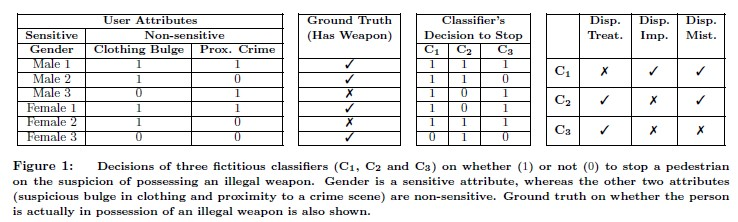

In [121]:
import pandas as pd
import numpy as np
import pickle
import scipy.optimize as optim
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
from __future__ import division
import os,sys
import numpy as np
import pandas as pd
from collections import defaultdict
from random import seed, shuffle
from collections import defaultdict
from copy import deepcopy
import numpy.core.multiarray
import cvxpy as cvx
import dccp
from dccp.problem import is_dccp
import utils as ut
import traceback

In [2]:
df = pd.read_csv('E:\compas-scores-two-years.csv')

In [77]:
features = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"] # feature classification
cont_feature = ["priors_count"] # continuous features 
sensitive_attrs = ["race"]

# convert df to np.array
data = df.to_dict('list')
for k in data.keys():
    data[k] = np.array(data[k])

# Data Filtering
idx = np.logical_and(data["days_b_screening_arrest"]<=30, data["days_b_screening_arrest"]>=-30)
idx = np.logical_and(idx, data["is_recid"] != -1)
idx = np.logical_and(idx, data["c_charge_degree"] != "O") 
idx = np.logical_and(idx, data["score_text"] != "NA")
idx = np.logical_and(idx, np.logical_or(data["race"] == "African-American", data["race"] == "Caucasian")) # regard African-American as 0,Caucasian as 1

for k in data.keys():
    data[k] = data[k][idx]
    
# convert class label 0 to -1
y = data['two_year_recid']
y[y==0] = -1

X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
x_control = defaultdict(list)

feature_names = []
for attr in features:
    vals = data[attr]
    if attr in cont_feature:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) # 0 mean and 1 variance  
        vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

    else: # for binary categorical variables, the label binarizer uses just one var instead of two
        lb = preprocessing.LabelBinarizer()
        lb.fit(vals)
        vals = lb.transform(vals)

        # add to sensitive features dict
    if attr in sensitive_attrs:
        x_control[attr] = vals


    # add to learnable features
    X = np.hstack((X, vals))

    if attr in cont_feature: # continuous feature, just append the name
        feature_names.append(attr)
    else: # categorical features
        if vals.shape[1] == 1: # binary features that passed through lib binarizer
            feature_names.append(attr)
        else:
            for k in lb.classes_: # non-binary categorical features, need to add the names for each cat
                feature_names.append(attr + "_" + str(k))


# convert the sensitive feature to 1-d array
x_control = dict(x_control)
for k in x_control.keys():
    assert(x_control[k].shape[1] == 1) # make sure that the sensitive feature is binary after one hot encoding
    x_control[k] = np.array(x_control[k]).flatten()

# sys.exit(1)

# permute the date randomly
perm = list(range(0,X.shape[0]))
shuffle(perm)
X = X[perm]
y = y[perm]
for k in x_control.keys():
    x_control[k] = x_control[k][perm]

# add intercept to data
m,n = X.shape
intercept = np.ones(m).reshape(m, 1)
X = np.concatenate((intercept,X), axis = 1)

feature_names = ["intercept"] + feature_names
assert(len(feature_names) == X.shape[1])
sensitive_attrs = x_control.keys()

In [78]:
def split_into_train_test(x_all, y_all, x_control_all, train_fold_size):

    split_point = int(round(float(x_all.shape[0]) * train_fold_size))
    x_all_train = x_all[:split_point]
    x_all_test = x_all[split_point:]
    y_all_train = y_all[:split_point]
    y_all_test = y_all[split_point:]
    x_control_all_train = {}
    x_control_all_test = {}
    for k in x_control_all.keys():
        x_control_all_train[k] = x_control_all[k][:split_point]
        x_control_all_test[k] = x_control_all[k][split_point:]

    return x_all_train, y_all_train, x_control_all_train, x_all_test, y_all_test, x_control_all_test

train_fold_size = 0.5
x_train, y_train, x_control_train, x_test, y_test, x_control_test = split_into_train_test(X, y, x_control, train_fold_size)

In [79]:
def train_model_disp_mist(x, y, x_control, loss_function, EPS, cons_params):

    # cons_type, sensitive_attrs_to_cov_thresh, take_initial_sol, gamma, tau, mu, EPS, cons_type
    """
    Function that trains the model subject to various fairness constraints.
    If no constraints are given, then simply trains an unaltered classifier.
    Example usage in: "disparate_mistreatment/synthetic_data_demo/decision_boundary_demo.py"
    ----
    Inputs:
    X: (n) x (d+1) numpy array -- n = number of examples, d = number of features, one feature is the intercept
    y: 1-d numpy array (n entries)
    x_control: dictionary of the type {"s": [...]}, key "s" is the sensitive feature name, and the value is a 1-d list with n elements holding the sensitive feature values
    loss_function: the loss function that we want to optimize -- for now we have implementation of logistic loss, but other functions like hinge loss can also be added
    EPS: stopping criteria for the convex solver. check the CVXPY documentation for details. default for CVXPY is 1e-6
    cons_params: is None when we do not want to apply any constraints
    otherwise: cons_params is a dict with keys as follows:
        - cons_type: 
            - 0 for all misclassifications 
            - 1 for FPR
            - 2 for FNR
            - 4 for both FPR and FNR
        - tau: DCCP parameter, controls how much weight to put on the constraints, if the constraints are not satisfied, then increase tau -- default is DCCP val 0.005
        - mu: DCCP parameter, controls the multiplicative factor by which the tau increases in each DCCP iteration -- default is the DCCP val 1.2
        - take_initial_sol: whether the starting point for DCCP should be the solution for the original (unconstrained) classifier -- default value is True
        - sensitive_attrs_to_cov_thresh: covariance threshold for each cons_type, eg, key 1 contains the FPR covariance
    ----
    Outputs:
    w: the learned weight vector for the classifier
    """

    max_iters = 100 # for the convex program
    max_iter_dccp = 50  # for the dccp algo

    
    num_points, num_features = x.shape
    w = cvx.Variable(num_features) # this is the weight vector

    # initialize a random value of w
    np.random.seed(112233)
    w.value = np.random.rand(x.shape[1])

    if cons_params is None: # just train a simple classifier, no fairness constraints
        constraints = []
    else:
        constraints = get_constraint_list_cov(x, y, x_control, cons_params["sensitive_attrs_to_cov_thresh"], cons_params["cons_type"], w)


    if loss_function == "logreg":
        # constructing the logistic loss problem
        loss = cvx.sum(  cvx.logistic( cvx.multiply(-y, x*w) )  ) / num_points # we are converting y to a diagonal matrix for consistent


    # sometimes, its a good idea to give a starting point to the constrained solver
    # this starting point for us is the solution to the unconstrained optimization problem
    # another option of starting point could be any feasible solution
    if cons_params is not None:
        if cons_params.get("take_initial_sol") is None: # true by default
            take_initial_sol = True
        elif cons_params["take_initial_sol"] == False:
            take_initial_sol = False

        if take_initial_sol == True: # get the initial solution
            p = cvx.Problem(cvx.Minimize(loss), [])
            p.solve()


    # construct the cvxpy problem
    prob = cvx.Problem(cvx.Minimize(loss), constraints)

    # print "\n\n"
    # print "Problem is DCP (disciplined convex program):", prob.is_dcp()
    # print "Problem is DCCP (disciplined convex-concave program):", is_dccp(prob)

    try:

        tau, mu = 0.005, 1.2 # default dccp parameters, need to be varied per dataset
        if cons_params is not None: # in case we passed these parameters as a part of dccp constraints
            if cons_params.get("tau") is not None: tau = cons_params["tau"]
            if cons_params.get("mu") is not None: mu = cons_params["mu"]

        prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10,
            solver='ECOS', verbose=False, 
            feastol=EPS, abstol=EPS, reltol=EPS,feastol_inacc=EPS, abstol_inacc=EPS, reltol_inacc=EPS,
            max_iters=max_iters, max_iter=max_iter_dccp)

        
        assert(prob.status == "Converged" or prob.status == "optimal")
        # print "Optimization done, problem status:", prob.status

    except:
        traceback.print_exc()
        sys.stdout.flush()
        sys.exit(1)


    # check that the fairness constraint is satisfied
    for f_c in constraints:
       # assert(f_c.value == True) # can comment this out if the solver fails too often, but make sure that the constraints are satisfied empirically. alternatively, consider increasing tau parameter
        pass
        

    w = np.array(w.value).flatten() # flatten converts it to a 1d array


    return w

In [80]:
def get_constraint_list_cov(x_train, y_train, x_control_train, sensitive_attrs_to_cov_thresh, cons_type, w):

    """
    get the list of constraints to be fed to the minimizer
    cons_type == 0: means the whole combined misclassification constraint (without FNR or FPR)
    cons_type == 1: FPR constraint
    cons_type == 2: FNR constraint
    cons_type == 4: both FPR as well as FNR constraints
    sensitive_attrs_to_cov_thresh: is a dict like {s: {cov_type: val}}
    s is the sensitive attr
    cov_type is the covariance type. contains the covariance for all misclassifications, FPR and for FNR etc
    """

    constraints = []
    for attr in sensitive_attrs_to_cov_thresh.keys():

        attr_arr = x_control_train[attr]
        attr_arr_transformed, index_dict = get_one_hot_encoding(attr_arr)
                
        if index_dict is None: # binary attribute, in this case, the attr_arr_transformed is the same as the attr_arr

            s_val_to_total = {ct:{} for ct in [0,1,2]} # constrain type -> sens_attr_val -> total number
            s_val_to_avg = {ct:{} for ct in [0,1,2]}
            cons_sum_dict = {ct:{} for ct in [0,1,2]} # sum of entities (females and males) in constraints are stored here

            for v in set(attr_arr):
                s_val_to_total[0][v] = sum(x_control_train[attr] == v)
                s_val_to_total[1][v] = sum(np.logical_and(x_control_train[attr] == v, y_train == -1)) # FPR constraint so we only consider the ground truth negative dataset for computing the covariance
                s_val_to_total[2][v] = sum(np.logical_and(x_control_train[attr] == v, y_train == +1))


            for ct in [0,1,2]:
                s_val_to_avg[ct][0] = s_val_to_total[ct][1] / float(s_val_to_total[ct][0] + s_val_to_total[ct][1]) # N1/N in our formulation, differs from one constraint type to another
                s_val_to_avg[ct][1] = 1.0 - s_val_to_avg[ct][0] # N0/N

            
            for v in set(attr_arr):

                idx = x_control_train[attr] == v                


                #################################################################
                # #DCCP constraints
                dist_bound_prod = cvx.multiply(y_train[idx], x_train[idx] * w) # y.f(x)
                
                cons_sum_dict[0][v] = cvx.sum( cvx.minimum(0, dist_bound_prod) ) * (s_val_to_avg[0][v] / len(x_train)) # avg misclassification distance from boundary
                cons_sum_dict[1][v] = cvx.sum( cvx.minimum(0, cvx.multiply( (1 - y_train[idx])/2.0, dist_bound_prod) ) ) * (s_val_to_avg[1][v] / sum(y_train == -1)) # avg false positive distance from boundary (only operates on the ground truth neg dataset)
                cons_sum_dict[2][v] = cvx.sum( cvx.minimum(0, cvx.multiply( (1 + y_train[idx])/2.0, dist_bound_prod) ) ) * (s_val_to_avg[2][v] / sum(y_train == +1)) # avg false negative distance from boundary
                #################################################################

                
            if cons_type == 4:
                cts = [1,2]
            elif cons_type in [0,1,2]:
                cts = [cons_type]
            
            else:
                raise Exception("Invalid constraint type")


            #################################################################
            #DCCP constraints
            for ct in cts:
                thresh = abs(sensitive_attrs_to_cov_thresh[attr][ct][1] - sensitive_attrs_to_cov_thresh[attr][ct][0])
                constraints.append( cons_sum_dict[ct][1] <= cons_sum_dict[ct][0]  + thresh )
                constraints.append( cons_sum_dict[ct][1] >= cons_sum_dict[ct][0]  - thresh )

            #################################################################


            
        else: # otherwise, its a categorical attribute, so we need to set the cov thresh for each value separately
            # need to fill up this part
            raise Exception("Fill the constraint code for categorical sensitive features... Exiting...")
            sys.exit(1)
            

    return constraints

In [81]:
def get_one_hot_encoding(in_arr):
    """
        input: 1-D arr with int vals -- if not int vals, will raise an error
        output: m (ndarray): one-hot encoded matrix
                d (dict): also returns a dictionary original_val -> column in encoded matrix
    """

    # for k in in_arr:
        #if str(type(k)) != "<type 'numpy.float64'>" and type(k) != int and type(k) != np.int64:
            # print (str(type(k)))
            # print ("************* ERROR: Input arr does not have integer types")
            # return None
        
    in_arr = np.array(in_arr, dtype=int)
    assert(len(in_arr.shape)==1) # no column, means it was a 1-D arr
    attr_vals_uniq_sorted = sorted(list(set(in_arr)))
    num_uniq_vals = len(attr_vals_uniq_sorted)
    if (num_uniq_vals == 2) and (attr_vals_uniq_sorted[0] == 0 and attr_vals_uniq_sorted[1] == 1):
        return in_arr, None

    
    index_dict = {} # value to the column number
    for i in range(0,len(attr_vals_uniq_sorted)):
        val = attr_vals_uniq_sorted[i]
        index_dict[val] = i

    out_arr = []    
    for i in range(0,len(in_arr)):
        tup = np.zeros(num_uniq_vals)
        val = in_arr[i]
        ind = index_dict[val]
        tup[ind] = 1 # set that value of tuple to 1
        out_arr.append(tup)

    return np.array(out_arr), index_dict

In [82]:
loss_function = "logreg" 
EPS = 1e-6
cons_type = 1 # FPR constraint -- just change the cons_type, the rest of parameters should stay the same
tau = 5.0
mu = 1.2
sensitive_attrs_to_cov_thresh = {"race": {0:{0:0, 1:0}, 1:{0:0, 1:0}, 2:{0:0, 1:0}}} # zero covariance threshold, means try to get the fairest solution
cons_params = {"cons_type": cons_type, 
"tau": tau, 
"mu": mu, 
"sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}
w = train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)

C:\Anaconda\lib\site-packages\cvxpy\expressions\expression.py:558: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 61 times so far.

  warnings.warn(msg, UserWarning)
C:\Anaconda\lib\site-packages\cvxpy\expressions\expression.py:558: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 62 times so far.

  warnings.warn(msg, UserWarning)
C:\Anaconda\lib\site-packages\cvxpy\expressi

In [83]:
distance_boundary = numpy.dot(X, w) # will give the distance from the decision boundary
predicted_labels = np.sign(distance_boundary) 

In [84]:
predicted_labels

array([ 1.,  1.,  1., ..., -1.,  1.,  1.])

In [85]:
d0 = y-predicted_labels
d1 = d0[d0 != 0]
all_pro = len(d1)/len(y)
# FPR y = -1, prediction = 1
d2 = d0[d0 == -2]
y2 = y[y == -1]
fpr_pro = len(d2)/len(y2)
# FNR y = 1, prediction = -1
d3 = d0[d0 == 2]
y3 = y[y == 1]
fnr_pro = len(d3)/len(y3)
print("ALL:"+str(all_pro),"FPR:"+str(fpr_pro),"FNR:"+str(fnr_pro))

ALL:0.35467980295566504 FPR:0.24329159212880144 FNR:0.4800644381796214


In [86]:
def get_fpr_fnr_sensitive_features(y_true, y_pred, x_control, sensitive_attrs, verbose = False):



    # we will make some changes to x_control in this function, so make a copy in order to preserve the origianl referenced object
    x_control_internal = deepcopy(x_control)

    s_attr_to_fp_fn = {}
    
    for s in sensitive_attrs:
        s_attr_to_fp_fn[s] = {}
        s_attr_vals = x_control_internal[s]
        if verbose == True:
            print( "||  s  || FPR. || FNR. ||")
        for s_val in sorted(list(set(s_attr_vals))):
            s_attr_to_fp_fn[s][s_val] = {}
            y_true_local = y_true[s_attr_vals==s_val]
            y_pred_local = y_pred[s_attr_vals==s_val]

            

            acc = float(sum(y_true_local==y_pred_local)) / len(y_true_local)

            fp = sum(np.logical_and(y_true_local == -1.0, y_pred_local == +1.0)) # something which is -ve but is misclassified as +ve
            fn = sum(np.logical_and(y_true_local == +1.0, y_pred_local == -1.0)) # something which is +ve but is misclassified as -ve
            tp = sum(np.logical_and(y_true_local == +1.0, y_pred_local == +1.0)) # something which is +ve AND is correctly classified as +ve
            tn = sum(np.logical_and(y_true_local == -1.0, y_pred_local == -1.0)) # something which is -ve AND is correctly classified as -ve

            all_neg = sum(y_true_local == -1.0)
            all_pos = sum(y_true_local == +1.0)

            fpr = float(fp) / float(fp + tn)
            fnr = float(fn) / float(fn + tp)
            tpr = float(tp) / float(tp + fn)
            tnr = float(tn) / float(tn + fp)


            s_attr_to_fp_fn[s][s_val]["fp"] = fp
            s_attr_to_fp_fn[s][s_val]["fn"] = fn
            s_attr_to_fp_fn[s][s_val]["fpr"] = fpr
            s_attr_to_fp_fn[s][s_val]["fnr"] = fnr

            s_attr_to_fp_fn[s][s_val]["acc"] = (tp + tn) / (tp + tn + fp + fn)
            if verbose == True:
                if isinstance(s_val, float): # print the int value of the sensitive attr val
                    s_val = int(s_val)
                print ("||  %s  || %0.2f || %0.2f ||" % (s_val, fpr, fnr))

        
        return s_attr_to_fp_fn

In [87]:
def get_sensitive_attr_constraint_fpr_fnr_cov(model, x_arr, y_arr_true, y_arr_dist_boundary, x_control_arr, verbose=False):

    
    """
    Here we compute the covariance between sensitive attr val and ONLY misclassification distances from boundary for False-positives
    (-N_1 / N) sum_0(min(0, y.f(x))) + (N_0 / N) sum_1(min(0, y.f(x))) for all misclassifications
    (-N_1 / N) sum_0(min(0, (1-y)/2 . y.f(x))) + (N_0 / N) sum_1(min(0,  (1-y)/2. y.f(x))) for FPR
    y_arr_true are the true class labels
    y_arr_dist_boundary are the predicted distances from the decision boundary
    If the model is None, we assume that the y_arr_dist_boundary contains the distace from the decision boundary
    If the model is not None, we just compute a dot product or model and x_arr
    for the case of SVM, we pass the distace from bounday becase the intercept in internalized for the class
    and we have compute the distance using the project function
    this function will return -1 if the constraint specified by thresh parameter is not satifsified
    otherwise it will reutrn +1
    if the return value is >=0, then the constraint is satisfied
    """

        
    assert(x_arr.shape[0] == x_control_arr.shape[0])
    if len(x_control_arr.shape) > 1: # make sure we just have one column in the array
        assert(x_control_arr.shape[1] == 1)
    if len(set(x_control_arr)) != 2: # non binary attr
        raise Exception("Non binary attr, fix to handle non bin attrs")

    
    arr = []
    if model is None:
        arr = y_arr_dist_boundary * y_arr_true # simply the output labels
    else:
        arr = np.dot(model, x_arr.T) * y_arr_true # the product with the weight vector -- the sign of this is the output label
    arr = np.array(arr)

    s_val_to_total = {ct:{} for ct in [0,1,2]}
    s_val_to_avg = {ct:{} for ct in [0,1,2]}
    cons_sum_dict = {ct:{} for ct in [0,1,2]} # sum of entities (females and males) in constraints are stored here

    for v in set(x_control_arr):
        s_val_to_total[0][v] = sum(x_control_arr == v)
        s_val_to_total[1][v] = sum(np.logical_and(x_control_arr == v, y_arr_true == -1))
        s_val_to_total[2][v] = sum(np.logical_and(x_control_arr == v, y_arr_true == +1))


    for ct in [0,1,2]:
        s_val_to_avg[ct][0] = s_val_to_total[ct][1] / float(s_val_to_total[ct][0] + s_val_to_total[ct][1]) # N1 / N
        s_val_to_avg[ct][1] = 1.0 - s_val_to_avg[ct][0] # N0 / N

    
    for v in set(x_control_arr):
        idx = x_control_arr == v
        dist_bound_prod = arr[idx]

        cons_sum_dict[0][v] = sum( np.minimum(0, dist_bound_prod) ) * (s_val_to_avg[0][v] / len(x_arr))
        cons_sum_dict[1][v] = sum( np.minimum(0, ( (1 - y_arr_true[idx]) / 2 ) * dist_bound_prod) ) * (s_val_to_avg[1][v] / sum(y_arr_true == -1))
        cons_sum_dict[2][v] = sum( np.minimum(0, ( (1 + y_arr_true[idx]) / 2 ) * dist_bound_prod) ) * (s_val_to_avg[2][v] / sum(y_arr_true == +1))
        

    cons_type_to_name = {0:"ALL", 1:"FPR", 2:"FNR"}
    for cons_type in [0,1,2]:
        cov_type_name = cons_type_to_name[cons_type]    
        cov = cons_sum_dict[cons_type][1] - cons_sum_dict[cons_type][0]
        if verbose == True:
            print( "Covariance for type '%s' is: %0.7f" %(cov_type_name, cov))
        
    return cons_sum_dict

In [88]:
def check_accuracy(model, x_train, y_train, x_test, y_test, y_train_predicted, y_test_predicted):


    """
    returns the train/test accuracy of the model
    we either pass the model (w)
    else we pass y_predicted
    """
    if model is not None and y_test_predicted is not None:
        print ("Either the model (w) or the predicted labels should be None")
        raise Exception("Either the model (w) or the predicted labels should be None")

    if model is not None:
        y_test_predicted = np.sign(np.dot(x_test, model))
        y_train_predicted = np.sign(np.dot(x_train, model))

    def get_accuracy(y, Y_predicted):
        correct_answers = (Y_predicted == y).astype(int) # will have 1 when the prediction and the actual label match
        accuracy = float(sum(correct_answers)) / float(len(correct_answers))
        return accuracy, sum(correct_answers)

    train_score, correct_answers_train = get_accuracy(y_train, y_train_predicted)
    test_score, correct_answers_test = get_accuracy(y_test, y_test_predicted)

    return train_score, test_score, correct_answers_train, correct_answers_test

In [89]:
def get_distance_boundary(w, x, s_attr_arr):

    """
        if we have boundaries per group, then use those separate boundaries for each sensitive group
        else, use the same weight vector for everything
    """

    distances_boundary = np.zeros(x.shape[0])
    if isinstance(w, dict): # if we have separate weight vectors per group
        for k in w.keys(): # for each w corresponding to each sensitive group
            d = np.dot(x, w[k])
            distances_boundary[s_attr_arr == k] = d[s_attr_arr == k] # set this distance only for people with this sensitive attr val
    else: # we just learn one w for everyone else
        distances_boundary = np.dot(x, w)
    return distances_boundary

In [90]:
def get_clf_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs):



    
    assert(len(sensitive_attrs) == 1) # ensure that we have just one sensitive attribute
    s_attr = "race" # for now, lets compute the accuracy for just one sensitive attr
    #s_attr = sensitive_attrs[0] # for now, lets compute the accuracy for just one sensitive attr


    # compute distance from boundary
    distances_boundary_train = get_distance_boundary(w, x_train, x_control_train[s_attr])
    distances_boundary_test = get_distance_boundary(w, x_test, x_control_test[s_attr])

    # compute the class labels
    all_class_labels_assigned_train = np.sign(distances_boundary_train)
    all_class_labels_assigned_test = np.sign(distances_boundary_test)


    train_score, test_score, correct_answers_train, correct_answers_test = check_accuracy(None, x_train, y_train, x_test, y_test, all_class_labels_assigned_train, all_class_labels_assigned_test)

    
    cov_all_train = {}
    cov_all_test = {}
    for s_attr in sensitive_attrs:
        
        
        print_stats = False # we arent printing the stats for the train set to avoid clutter

        # uncomment these lines to print stats for the train fold
        # print "*** Train ***"
        # print "Accuracy: %0.3f" % (train_score)
        # print_stats = True
        s_attr_to_fp_fn_train = get_fpr_fnr_sensitive_features(y_train, all_class_labels_assigned_train, x_control_train, sensitive_attrs, print_stats)
        cov_all_train[s_attr] = get_sensitive_attr_constraint_fpr_fnr_cov(None, x_train, y_train, distances_boundary_train, x_control_train[s_attr]) 
        

        print ("\n")
        print( "Accuracy: %0.3f" % (test_score))
        print_stats = True # only print stats for the test fold
        s_attr_to_fp_fn_test = get_fpr_fnr_sensitive_features(y_test, all_class_labels_assigned_test, x_control_test, sensitive_attrs, print_stats)
        cov_all_test[s_attr] = get_sensitive_attr_constraint_fpr_fnr_cov(None, x_test, y_test, distances_boundary_test, x_control_test[s_attr]) 
        print ("\n")

    return train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test

In [91]:
def train_test_classifier():
    w = train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)

    train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = get_clf_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

    # accuracy and FPR are for the test because we need of for plotting
    return w, test_score, s_attr_to_fp_fn_test

In [95]:
""" Classify the data while optimizing for accuracy """
cons_params = None
print("== Unconstrained (original) classifier ==")
w_uncons, acc_uncons, s_attr_to_fp_fn_test_uncons = train_test_classifier()
# print("\n-----------------------------------------------------------------------------------\n")

""" Now classify such that we optimize for accuracy while achieving perfect fairness """
print("\n\n== Constraints on FPR ==") # setting parameter for constraints
cons_type = 1 # FPR constraint -- just change the cons_type, the rest of parameters should stay the same
tau = 5.0
mu = 1.2
sensitive_attrs_to_cov_thresh = {"race": {0:{0:0, 1:0}, 1:{0:0, 1:0}, 2:{0:0, 1:0}}} # zero covariance threshold, means try to get the fairest solution
cons_params = {"cons_type": cons_type, "tau": tau, "mu": mu, "sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}

w_cons, acc_cons, s_attr_to_fp_fn_test_cons  = train_test_classifier()

== Unconstrained (original) classifier ==


C:\Anaconda\lib\site-packages\cvxpy\expressions\expression.py:558: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 76 times so far.

  warnings.warn(msg, UserWarning)




Accuracy: 0.664
||  s  || FPR. || FNR. ||
||  0  || 0.33 || 0.32 ||
||  1  || 0.18 || 0.63 ||




== Constraints on FPR ==


C:\Anaconda\lib\site-packages\cvxpy\expressions\expression.py:558: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 77 times so far.

  warnings.warn(msg, UserWarning)
C:\Anaconda\lib\site-packages\cvxpy\expressions\expression.py:558: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 78 times so far.

  warnings.warn(msg, UserWarning)
C:\Anaconda\lib\site-packages\cvxpy\expressi



Accuracy: 0.634
||  s  || FPR. || FNR. ||
||  0  || 0.24 || 0.45 ||
||  1  || 0.28 || 0.53 ||




In [119]:
import matplotlib
import matplotlib.pyplot as plt # for plotting stuff
import os

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams.update({'figure.autolayout': True})

def get_line_coordinates(w, x1, x2):
    y1 = (-w[0] - (w[1] * x1)) / w[2]
    y2 = (-w[0] - (w[1] * x2)) / w[2]    
    return y1,y2
def plot_boundaries(X, y, x_control, w_arr, acc_arr, fp_fn_arr):

    # print fp_fn_arr
    plt.figure()
    num_to_draw = 200 # we will only draw a small number of points to avoid clutter

    x_draw = X[:num_to_draw]
    y_draw = y[:num_to_draw]
    x_control_draw = x_control['race'][:num_to_draw]

    X_s_0 = x_draw[x_control_draw == 0.0]
    X_s_1 = x_draw[x_control_draw == 1.0]
    y_s_0 = y_draw[x_control_draw == 0.0]
    y_s_1 = y_draw[x_control_draw == 1.0]
    plt.scatter(X_s_0[y_s_0==1.0][:, 1], X_s_0[y_s_0==1.0][:, 2], color='green', marker='x', s=60, linewidth=2)
    plt.scatter(X_s_0[y_s_0==-1.0][:, 1], X_s_0[y_s_0==-1.0][:, 2], color='red', marker='x', s=60, linewidth=2)
    plt.scatter(X_s_1[y_s_1==1.0][:, 1], X_s_1[y_s_1==1.0][:, 2], color='green', marker='o', facecolors='none', s=60, linewidth=2)
    plt.scatter(X_s_1[y_s_1==-1.0][:, 1], X_s_1[y_s_1==-1.0][:, 2], color='red', marker='o', facecolors='none', s=60, linewidth=2)


    assert(len(w_arr) == len(acc_arr))
    assert(len(w_arr) == len(fp_fn_arr))

    line_styles = ['c-', 'b--', 'k--', 'c--', 'b--']


    for i in range(0,len(w_arr)):
        x1,x2 = max(x_draw[:,1])-2, min(x_draw[:,1])
        y1,y2 = get_line_coordinates(w_arr[i], x1, x2)


        #l = "Acc=%0.2f; FPR=%0.2f:%0.2f; FNR=%0.2f:%0.2f"%(acc_arr[i], fp_fn_arr[i][0.0]["fpr"], fp_fn_arr[i][1.0]["fpr"], fp_fn_arr[i][0.0]["fnr"], fp_fn_arr[i][1.0]["fnr"])
        plt.plot([x1,x2], [y1,y2], line_styles[i], linewidth=5,label ="line 1")
        #plt.plot([x1,x2], [y1,y2], line_styles[i], linewidth=5, label = l)




    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.legend(loc=2, fontsize=21)

    plt.ylim((-8,12))

    plt.show()

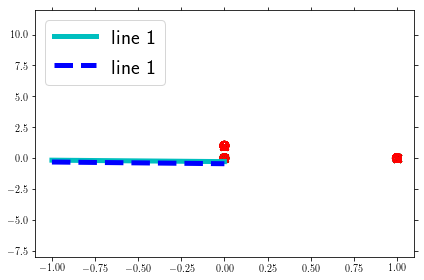

In [120]:
plot_boundaries(X, y, x_control, [w_uncons, w_cons], [acc_uncons, acc_cons], [s_attr_to_fp_fn_test_uncons, s_attr_to_fp_fn_test_cons])